# Journal life stories

In [1]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
meta = pd.read_csv('../metadata/litstudies/LitMetadataWithS2.tsv', sep = '\t')
meta = meta.loc[~pd.isnull(meta.paperId), : ]
meta.rename(columns={'paperId': 'docid'}, inplace=True)
meta.set_index('docid', inplace = True)

In [105]:
decades = []

for decade in range(20, 100, 10):

    # df = pd.read_csv('../topicmodel/flatresults/precocity_flat_19' + str(decade) + 's_docs.tsv', sep = '\t')
    df = pd.read_csv('../tunedembeddings/para20/precocity_tuned_19' + str(decade) + 's_docs.tsv', sep = '\t')
    decades.append(df)

df = pd.concat(decades)
df.shape


(1359024, 10)

In [106]:
df.set_index('docid', inplace=True)

df = df.join(meta['new_cite_count'], how='inner')
df['logcitations'] = np.log(df.new_cite_count + 1)

In [95]:
meta.doctype.value_counts()

doctype
article | research-article    22810
article | book-review         17335
article | misc                  239
article | editorial               7
article | review-article          5
article | books-received          4
article | other                   3
article | brief-report            2
article | correction              1
article | letter                  1
Name: count, dtype: int64

In [11]:
print(meta['S2journal'].unique())

[nan 'The Review of English Studies'
 'PMLA/Publications of the Modern Language Association of America'
 'Modern Philology' 'ELH' 'no journal listed' 'New Literary History'
 'Critical Inquiry' 'Modern Language Review'
 'Pmla-publications of The Modern Language Association of America'
 'Prosthetics and Orthotics International' 'Theoretical Inquiries in Law'
 'Neohelicon' 'Journal of the Royal Asiatic Society' 'Textual Practice'
 'Publications of the Modern Language Association of America'
 'Laboratory Animals' 'The Romanic Review' 'The History Teacher'
 'The Modern Language Journal' 'NASSP Bulletin' 'Modern Language Notes'
 'Teachers College Record: The Voice of Scholarship in Education'
 'Shamans in Turtlenecks' 'Diogenes' 'The Analytic Attitude'
 'English Studies' 'Interdisciplinary Science Reviews']


In [12]:
# Create a table of the number of documents in each journal
journal_counts = meta['S2journal'].value_counts().reset_index()
journal_counts.columns = ['journal', 'count']
journal_counts 

,journal,count
0,PMLA/Publications of the Modern Language Assoc...,2959
1,Modern Philology,2666
2,The Review of English Studies,2137
3,Modern Language Review,1197
4,Critical Inquiry,1110
5,no journal listed,1002
6,ELH,989
7,New Literary History,907
8,Pmla-publications of The Modern Language Assoc...,78
9,English Studies,1


In [49]:
# Change all occurrences of 'Pmla-publications of The Modern Language Association of America' to 'PMLA'
meta['S2journal'] = meta['S2journal'].replace('Pmla-publications of The Modern Language Association of America', 'PMLA')

# Change all occurrences of 'PMLA/Publications of the Modern Language Association of America' to 'PMLA'
meta['S2journal'] = meta['S2journal'].replace('PMLA/Publications of the Modern Language Association of America', 'PMLA')

# Change all occurrences of "The Review of English Studies" to "English Studies"
meta['S2journal'] = meta['S2journal'].replace('The Review of English Studies', 'English Studies')

# Change all occurrences of "New Literary History" to "NLH"
meta['S2journal'] = meta['S2journal'].replace('New Literary History', 'NLH')

# Allowable journal values are
# PMLA
# Modern Philology
# English Studies
# ELH
# Modern Language Review
# Critical Inquiry
# NLH

# For all rows that are not in allowable journals, including those where journal is missing
# set the journal to 'Other'

for index, row in meta.iterrows():
    if row['S2journal'] not in ['PMLA', 'Modern Philology', 'English Studies', 'ELH', 'Modern Language Review', 'Critical Inquiry', 'NLH']:
        meta.at[index, 'S2journal'] = 'Other'

In [50]:
df.shape

(1359024, 11)

In [107]:
bestdf = df.loc[(df.time_radius == 20) & (df.filtered == 'trainauthquote') &
            (df.chunks_used == 0.25) & (df.fraction_compared == 1.0), :]
bestdf.shape

(28313, 11)

In [108]:
bestdf = bestdf.join(meta['S2journal'], how='inner')
bestdf = bestdf.join(meta['doctype'], how='inner')
bestdf = bestdf.loc[bestdf.doctype == 'article | research-article', : ]

In [23]:
bestdf.columns

Index(['date', 'num_chunks', 'fraction_compared', 'filtered', 'time_radius',
       'chunks_used', 'precocity', 'novelty', 'transience', 'new_cite_count',
       'logcitations', 'S2journal'],
      dtype='object')

In [109]:
# Group bestdf by year. For each year, calculate z scores for logcitations
# and precocity. Create two new columns, z_logcitations and z_precocity,
# that contain the z scores for each year. Rejoin the year groups to produce
# a new dataframe zdf, which contains the z scores for each year.

newdfs = []
grouped_bestdf = bestdf.groupby('date')
for name, group in grouped_bestdf:
    group['z_logcitations'] = (group.logcitations - group.logcitations.mean()) / group.logcitations.std()
    group['z_precocity'] = (group.precocity - group.precocity.mean()) / group.precocity.std()
    newdfs.append(group)

zdf = pd.concat(newdfs)

In [110]:
# For each journal, calculate the average z_logcitations and z_precocity.
# Create a new dataframe, journal_z, that contains the average z scores for
# each journal. Then use seaborn to create a scatterplot of z_logcitations
# and z_precocity, with the points colored by journal.

journal_z = zdf.groupby('S2journal').mean(['z_logcitations', 'z_precocity']).reset_index()
journal_z

,S2journal,date,num_chunks,fraction_compared,time_radius,chunks_used,precocity,novelty,transience,new_cite_count,logcitations,z_logcitations,z_precocity
0,Critical Inquiry,1984.451389,26.531250,1.0,20.0,0.25,0.024893,-0.011509,-0.036402,48.271991,2.557053,0.648634,0.530823
1,ELH,1979.088608,28.025316,1.0,20.0,0.25,0.012642,-0.019057,-0.031698,8.856540,1.308747,-0.303168,-0.007973
2,English Studies,1957.591299,13.719363,1.0,20.0,0.25,0.005114,-0.008198,-0.013313,3.659314,1.055986,-0.114342,-0.249692
3,Modern Language Review,1953.093923,13.071823,1.0,20.0,0.25,0.000951,-0.012235,-0.013186,0.058011,0.020873,-1.107827,-0.434428
4,Modern Philology,1955.720284,20.866943,1.0,20.0,0.25,0.006175,-0.013266,-0.019441,4.523950,1.082782,-0.053817,-0.122906
5,NLH,1990.048485,20.157576,1.0,20.0,0.25,0.018183,-0.016067,-0.034250,11.145455,1.287374,-0.345909,0.204573
6,Other,1961.847163,22.785455,1.0,20.0,0.25,0.009946,-0.012242,-0.022188,7.310634,1.421073,0.177667,0.034798
7,PMLA,1954.599849,19.841748,1.0,20.0,0.25,0.008397,-0.011348,-0.019745,1.730219,0.400857,-0.726562,0.093119


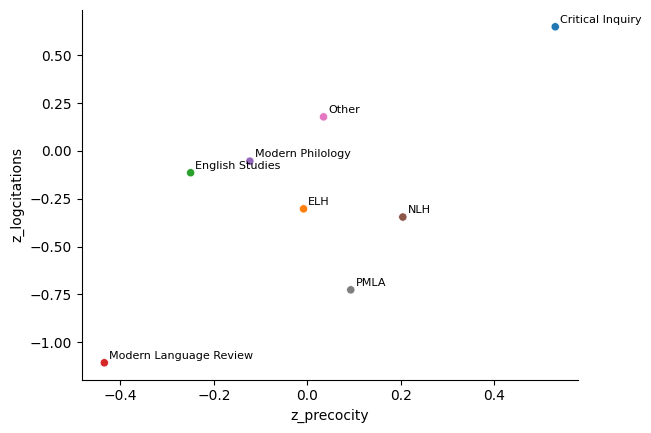

In [111]:
# Your code for creating the scatterplot
sns.scatterplot(data=journal_z, x='z_precocity', y='z_logcitations', hue='S2journal', legend = False)

for idx, row in journal_z.iterrows():
    plt.text(row['z_precocity'] + 0.01, row['z_logcitations'] + 0.02, row['S2journal'], fontsize=8)

# Remove the upper and right edges
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('JournalPlotEmbeds.png', dpi=300, bbox_inches='tight')

plt.show()



<Axes: xlabel='date', ylabel='z_precocity'>

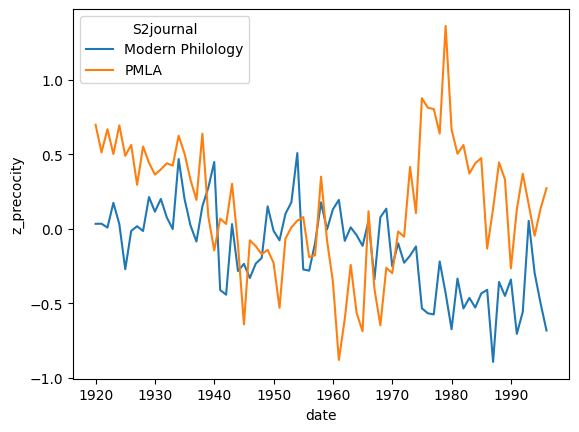

In [115]:
# Group zdf by journal and year. For each journal and year, calculate the
# mean z_logcitations and z_precocity. Plot line graphs of z_precocity
# and z_logcitations for PMLA, ELH, NLH, and Critical Inquiry, where
# the x-axis is year and the y-axis is the z score. The lines should be
# colored by journal.

journalyear = zdf.groupby(['date', 'S2journal']).mean(['z_logcitations', 'z_precocity']).reset_index()

journalyear = journalyear.loc[journalyear.S2journal.isin(['PMLA', 'Modern Philology']), :]

sns.lineplot(data=journalyear, x='date', y='z_precocity', hue='S2journal')


In [91]:
# zdf by date and print mean z_precocity for each year
journalyear = zdf.groupby(['date', 'S2journal']).mean(['z_logcitations', 'z_precocity']).reset_index()
journalyear.loc[journalyear.date == 1980, :]

,date,S2journal,num_chunks,fraction_compared,time_radius,chunks_used,precocity,novelty,transience,new_cite_count,logcitations,z_logcitations,z_precocity
350,1980,Critical Inquiry,10.375000,1.0,20.0,0.25,0.312587,5.666395,5.353808,107.229167,2.649486,0.955472,0.742919
351,1980,ELH,13.666667,1.0,20.0,0.25,0.264084,5.188202,4.924118,0.000000,0.000000,-1.064129,0.099927
352,1980,English Studies,8.277778,1.0,20.0,0.25,0.180468,5.399416,5.218948,4.777778,1.363728,-0.024612,-1.008538
353,1980,Modern Language Review,10.571429,1.0,20.0,0.25,0.245409,5.372075,5.126666,0.428571,0.198042,-0.913169,-0.147640
354,1980,Modern Philology,8.222222,1.0,20.0,0.25,0.186031,6.051374,5.865343,1.388889,0.584166,-0.618842,-0.934797
355,1980,NLH,5.000000,1.0,20.0,0.25,0.404550,5.958756,5.554206,0.000000,0.000000,-1.064129,1.962043
356,1980,Other,5.575000,1.0,20.0,0.25,0.255534,5.590927,5.335393,6.945000,1.335961,-0.045778,-0.013413
357,1980,PMLA,3.800000,1.0,20.0,0.25,0.308697,5.107932,4.799235,0.000000,0.000000,-1.064129,0.691354
